<h2 style="text-align:center;color:blue">Risk Assessment of loan applications</h2>
<h4 style="text-align:right;color:green">Utkarsh</h4>


#### Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.3f}'.format)
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

#### Load Dataframe

In [2]:
#load data in dataframe
loan_master = pd.read_csv('loan.csv',low_memory=False)

In [3]:
#check number of rows and columns
loan_master.shape

(39717, 111)

In [4]:
loan_master.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 111 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              39717 non-null  int64  
 1   member_id                       39717 non-null  int64  
 2   loan_amnt                       39717 non-null  int64  
 3   funded_amnt                     39717 non-null  int64  
 4   funded_amnt_inv                 39717 non-null  float64
 5   term                            39717 non-null  object 
 6   int_rate                        39717 non-null  object 
 7   installment                     39717 non-null  float64
 8   grade                           39717 non-null  object 
 9   sub_grade                       39717 non-null  object 
 10  emp_title                       37258 non-null  object 
 11  emp_length                      38642 non-null  object 
 12  home_ownership                 

### Data Cleaning - Starts Here

#### User Defined Functions for Data Cleaning

In [5]:
#function to check for nulls and only display the columns having null count>0
def check_null(dataframe, percentage=True):
    if percentage==True:
        return round(dataframe.isnull().mean()[dataframe.isnull().mean()>0].apply(lambda x: x*100),3)
    else:
        return dataframe.isnull().sum()[dataframe.isnull().sum()>0]
    
#function to drop irrelevant columns
def drop_irrelevant_columns(dataframe, column_list):
    dataframe.drop(column_list, axis=1, inplace=True, errors='ignore')
    
#function to drop columns based on NULLs percentage
def dropna_cols_perc(dataframe, percentage):
    n_thresh = int(len(loan_master)*(1-(percentage/100)))
    dataframe.dropna(axis=1, thresh=n_thresh, inplace=True)

#function to drop rows of columns with insignificant nulls
def drop_insignificant_rows(df,col_subset_list):
    df.dropna(subset=col_subset_list, inplace=True)

#function to print column details
def tell_about_columns(df, *col_names):
    for data in col_names:
        print(f"Column name: {data} {'*'*5} Nunique: {df[data].nunique()}, Dtype: {df[data].dtype}, Null Count: {df[data].isna().sum()}")

#Print mean and median in one line for easier lookup
def get_mean_median(data):
    return f"Mean is: {data.mean()}, Median is: {data.median()}"

#### Data Cleaning - Handle Nulls

In [6]:
#check columns having nulls
check_null(loan_master)

emp_title                      6.191
emp_length                     2.707
desc                          32.581
title                          0.028
mths_since_last_delinq        64.662
                               ...  
tax_liens                      0.098
tot_hi_cred_lim              100.000
total_bal_ex_mort            100.000
total_bc_limit               100.000
total_il_high_credit_limit   100.000
Length: 68, dtype: float64

In [7]:
# Dropping the columns having all null values
loan_master.dropna(axis=1, how='all', inplace=True)
#check shape again
loan_master.shape

(39717, 57)

##### Above we saw that we are left with 57 columns now after removing the columns where all values are null. Let us clean further

In [8]:
#check again for columns having nulls
check_null(loan_master)

emp_title                     6.191
emp_length                    2.707
desc                         32.581
title                         0.028
mths_since_last_delinq       64.662
mths_since_last_record       92.985
revol_util                    0.126
last_pymnt_d                  0.179
next_pymnt_d                 97.130
last_credit_pull_d            0.005
collections_12_mths_ex_med    0.141
chargeoff_within_12_mths      0.141
pub_rec_bankruptcies          1.755
tax_liens                     0.098
dtype: float64

In [9]:
# Dropping the columns where null precentage is more than 60% as it will not help in any conclusion
dropna_cols_perc(loan_master,60)

#Checking the shape again
loan_master.shape

(39717, 54)

In [10]:
#check again for columns having nulls
check_null(loan_master)

emp_title                     6.191
emp_length                    2.707
desc                         32.581
title                         0.028
revol_util                    0.126
last_pymnt_d                  0.179
last_credit_pull_d            0.005
collections_12_mths_ex_med    0.141
chargeoff_within_12_mths      0.141
pub_rec_bankruptcies          1.755
tax_liens                     0.098
dtype: float64

#### Checking and dropping any irrelevent columns

There are a few columns having a single unique value or all unique values. These may have nothing much to contribute to the analysis i.e. columns which are far from being the driving columns towards loan default. Some other columns are redundant.
<br>
These columns are:
1. **member_id** - member identification number, does not contribute to analysis. Verified to be unique.
2. **desc** - It is description added by users. NOt useful now as it is textual data.
3. **zip_code** - first 3 digits of the 5 digit zip code are visible, also is redundant with addr_state, does not contribute to analysis
4. **url** - is a URL for LC page for corresponding to each memberid, nothing to do with loan default.
5. **acc_now_delinq** - All values are 0, therefore can be removed.
6. **title** - Large number of values which is unclassified, used purpose instead.
7. **application_type** - All values are INDIVIDUAL, will not be useful for analysis.
8. **chargeoff_within_12_mths** - All values are either 0 of null, will not be useful
9. **collections_12_mths_ex_med** - All values are either 0 or null, will not be useful.
10. **delinq_amnt** - All values are 0, therefore can be removed.
11. **initial_list_status** - value for entire dataset is 'f' out of the possible values, therefore can be removed.
12. **policy_code** - All values are 1, indicating all are publicly available, therefore nothing to contribute for analysis, to be removed.
13. **tax_liens** - All values are either 0 or Nan, so can be removed.
14. **pymnt_plan** - All values are n, can be removed

In [11]:
#list columns that are determined to be irrelevant to our analysis
list_irrelevant_cols=[]
list_irrelevant_cols.append('member_id') #Unique ID, will not be insightful. We have id column to measure uniqueness.
list_irrelevant_cols.append('desc') #text entered by borrower 
list_irrelevant_cols.append('zip_code') #first 3 chars only followed by xx
list_irrelevant_cols.append('url') #loan id already available
list_irrelevant_cols.append('acc_now_delinq') #only having 0s/Nas
list_irrelevant_cols.append('title') #use purpose instead
list_irrelevant_cols.append('application_type') #all loans are individual
list_irrelevant_cols.append('chargeoff_within_12_mths') #only having 0s/Nas
list_irrelevant_cols.append('collections_12_mths_ex_med') #only having 0s/Nas
list_irrelevant_cols.append('delinq_amnt') #only having 0s/Nas
list_irrelevant_cols.append('initial_list_status') #only having value f
list_irrelevant_cols.append('policy_code') #only having value 1
list_irrelevant_cols.append('tax_liens') #only having 0s/Nas
list_irrelevant_cols.append('pymnt_plan') #only having 0s/Nas

In [12]:
# Dropping the irrelevent columns
drop_irrelevant_columns(loan_master,list_irrelevant_cols)

#Checking shape after removing irrelevent columns
loan_master.shape

(39717, 40)

In [13]:
#check again for columns having nulls
check_null(loan_master)

emp_title              6.191
emp_length             2.707
revol_util             0.126
last_pymnt_d           0.179
last_credit_pull_d     0.005
pub_rec_bankruptcies   1.755
dtype: float64

##### Let us analyse the above columns and treat them accordingly.

In [14]:
tell_about_columns(loan_master, 'emp_title','emp_length')

Column name: emp_title ***** Nunique: 28820, Dtype: object, Null Count: 2459
Column name: emp_length ***** Nunique: 11, Dtype: object, Null Count: 1075


In [15]:
# As the dtype is object and the null count is insignificant, instead of imputing better we choose to drop it to avoid any biasness.
# Dropping the rows where these columns values are null
drop_insignificant_rows(loan_master,['emp_title','emp_length'])

In [16]:
#Let us analyse the columns with very less null counts
tell_about_columns(loan_master, 'revol_util','last_pymnt_d','last_credit_pull_d','pub_rec_bankruptcies')

Column name: revol_util ***** Nunique: 1082, Dtype: object, Null Count: 46
Column name: last_pymnt_d ***** Nunique: 101, Dtype: object, Null Count: 64
Column name: last_credit_pull_d ***** Nunique: 106, Dtype: object, Null Count: 0
Column name: pub_rec_bankruptcies ***** Nunique: 3, Dtype: float64, Null Count: 654


In [17]:
# Treating pub_rec_bankruptcies 
loan_master['pub_rec_bankruptcies'].value_counts()

0.000    35039
1.000     1502
2.000        7
Name: pub_rec_bankruptcies, dtype: int64

##### pub_rec_bankruptcies has either value 0 or 1 or 2, we can replace then with mode but we decided to drop null rows to avoid any introduced biasness and for last_pymnt_d it is of date type column so unable to impute it properly and dropping it finally

In [18]:
drop_insignificant_rows(loan_master,['pub_rec_bankruptcies','last_pymnt_d'])

##### Let us treat revol_util by trying to impute it with suitable value

In [19]:
loan_master['revol_util'] = loan_master['revol_util'].str.replace('%','').str.strip().astype(float)

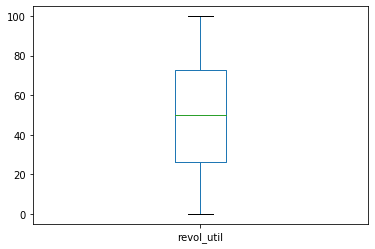

In [20]:
loan_master['revol_util'].plot(kind='box')
plt.show()

In [21]:
# Checking mean of revol_util before imputation
get_mean_median(loan_master['revol_util'])

'Mean is: 49.276383568409855, Median is: 49.9'

In [22]:
loan_master['revol_util'] = loan_master['revol_util'].fillna(loan_master['revol_util'].mean())

In [23]:
# Checking mean of revol_util after imputation
get_mean_median(loan_master['revol_util'])

'Mean is: 49.27638356840974, Median is: 49.8'

##### We can see that after imputation mean and median is almost same as before imputation, so we are moving forward with this.

In [24]:
#check again, columns having nulls
check_null(loan_master,percentage=False)

Series([], dtype: int64)

##### We have handled all the Nulls present in the data. Let us move forward

#### Data Cleaning - Handle Data Types

In [25]:
#fix data type for 'term' as int
loan_master['term'] = loan_master['term'].str.replace('months','').str.strip().astype(int)
#loan_master = loan_master.rename(columns={'term':'term_months'})

In [26]:
#fix data type for 'int_rate' as 'float' 
loan_master['int_rate'] = loan_master['int_rate'].str.strip('%').astype(float)

In [27]:
#fix data type emp_length
loan_master['emp_length'].value_counts()

10+ years    8409
2 years      4183
< 1 year     4063
3 years      3918
4 years      3305
5 years      3135
1 year       3031
6 years      2125
7 years      1700
8 years      1407
9 years      1208
Name: emp_length, dtype: int64

In [28]:
emp_length_dict = {
    '< 1 year' : 0,
    '1 year' : 1,
    '2 years' : 2,
    '3 years' : 3,
    '4 years' : 4,
    '5 years' : 5,
    '6 years' : 6,
    '7 years' : 7,
    '8 years' : 8,
    '9 years' : 9,
    '10+ years' : 10
}

In [29]:
loan_master = loan_master.replace({'emp_length': emp_length_dict })

#### Treating and analyzing datetime columns

In [30]:
#Converting the datetime cols into datetime datatype
loan_master[['issue_d','last_credit_pull_d','last_pymnt_d','earliest_cr_line']] = \
loan_master[['issue_d','last_credit_pull_d','last_pymnt_d','earliest_cr_line']].apply(pd.to_datetime,format='%b-%y') 

##### Datetime - sanity checks

In [31]:
# Checking the validity as it is mentioned that Issue date lies between 2007 to 2011
print('Invalid rows in issue_d:',loan_master[(loan_master['issue_d'] > '2011-12-31') | (loan_master['issue_d'] < '2007-01-01')].shape[0])

Invalid rows in issue_d: 0


In [32]:
# Checking for invalid future rows
date_today = pd.to_datetime('today')
print('Invalid future rows in last_credit_pull_d:',loan_master[(loan_master['last_credit_pull_d'] > date_today)].shape[0])
print('Invalid future rows in last_pymnt_d:',loan_master[(loan_master['last_pymnt_d'] > date_today)].shape[0])
print('Invalid future rows in earliest_cr_line:',loan_master[(loan_master['earliest_cr_line'] > date_today)].shape[0])

Invalid future rows in last_credit_pull_d: 0
Invalid future rows in last_pymnt_d: 0
Invalid future rows in earliest_cr_line: 50


##### earliest_cr_line is having some invalid future rows due to datetime conversion - fixing them

In [33]:
#determine cut off year for earliest_cr_line
print('cut off based on last credit pull', loan_master['last_credit_pull_d'].dt.year.max())

cut off based on last credit pull 2016


In [34]:
#fix earliest_cr_line to change century (year-100) for all rows > 2016
loan_master['earliest_cr_line'] = loan_master['earliest_cr_line'].apply(lambda x: x if x.year<=2016 else date(x.year-100,x.month,x.day))

In [35]:
#recheck invalid future rows
print('Invalid future rows in earliest_cr_line:',loan_master[(loan_master['earliest_cr_line'] > date_today)].shape[0])

Invalid future rows in earliest_cr_line: 0


#### Derived Metrics

In [36]:
#derive year from all date columns - for easier analysis later 
loan_master['earliest_cr_line_year'] = loan_master['earliest_cr_line'].dt.year
loan_master['last_credit_pull_year'] = loan_master['last_credit_pull_d'].dt.year
loan_master['last_pymnt_year'] = loan_master['last_pymnt_d'].dt.year
loan_master['issue_year'] = loan_master['issue_d'].dt.year

In [37]:
#check qcut range for int rate
pd.qcut(loan_master['int_rate'],5).value_counts()

(7.9, 10.99]      7571
(5.419, 7.9]      7326
(10.99, 12.99]    7243
(15.28, 24.4]     7200
(12.99, 15.28]    7144
Name: int_rate, dtype: int64

In [38]:
#add buckets with labels to int rate for better plotting
loan_master['int_rate_buckets'] = pd.qcut(loan_master['int_rate'],5,["5%-8%","8%-11%","11%-13%","13%-15%","15% and above"])
loan_master['int_rate_buckets']

1              13%-15%
3              13%-15%
4              11%-13%
5                5%-8%
6        15% and above
             ...      
39551           8%-11%
39562           8%-11%
39623          11%-13%
39666          11%-13%
39680          11%-13%
Name: int_rate_buckets, Length: 36484, dtype: category
Categories (5, object): ['5%-8%' < '8%-11%' < '11%-13%' < '13%-15%' < '15% and above']

In [39]:
#check qcut range for funded_amnt
pd.qcut(loan_master['funded_amnt'],5).value_counts()

(499.999, 5000.0]     8627
(11500.0, 16000.0]    7531
(5000.0, 8000.0]      7294
(16000.0, 35000.0]    6999
(8000.0, 11500.0]     6033
Name: funded_amnt, dtype: int64

In [40]:
#add buckets to funded_amnt for better plotting
loan_master['funded_amnt_buckets'] = pd.qcut(loan_master['funded_amnt'],5,["0.5k-5k","5k-8k","8k-12k","12k-16K","16K and above"])

In [41]:
#add buckets to annual_inc for better plotting
loan_master['annual_inc_buckets'] = pd.qcut(loan_master['annual_inc'],10)

In [42]:
#check qcut range for installment
pd.qcut(loan_master['installment'],5).value_counts()

(152.54, 234.82]                7305
(483.56, 1305.19]               7297
(332.484, 483.56]               7297
(16.078999999999997, 152.54]    7297
(234.82, 332.484]               7288
Name: installment, dtype: int64

In [43]:
#add buckets to installment for better plotting
loan_master['installment_buckets'] = pd.qcut(loan_master['installment'],5,['0-150','150-235','235-335','335-485','485+'])

In [44]:
#check qcut range for open_acc
loan_master['open_acc_buckets'] = pd.qcut(loan_master['open_acc'],5,['2-6','6-8','8-10','10-13','13+'])

In [45]:
# Final shape of data before starting analysis
loan_master.shape

(36484, 49)

### Analysis

In [46]:
#filter loan master to only have charged off and fully paid loans
#current loans are not required for our analysis as it will not give insight on actual parameters for loan status
loan_master_fp_co = loan_master[loan_master['loan_status']!='Current']

##### User defined functions for plotting

In [47]:
#annotate_bar function taken from https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
#and modified as per requirement in our case
sns.set(style='whitegrid')
def annotate_bar(ax,percent=False,fontsize=10): 
    """Add labels to the end of each bar in a bar chart.
       Function taken from https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
       ----------Edited as per requirement----------
    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = 2
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        if percent:
            label = "{:.1f}%".format(y_value)
        else:
            label = "{:.1f}".format(y_value)
            

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            fontsize=fontsize,          # Set font size
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.
            
#plot segmented comparison for a column on charge off vs fully paid loans
def comparison_plot(dataframe, col_name, rotate=False, palette_name = 'husl'):
    """
    This function plots the graph for number of Loan Status in Fully Paid or Charged Off for the given category.
    """
    d1 = pd.pivot_table(dataframe, index=['loan_status',col_name], values='id', aggfunc='count').reset_index()  
    d2 = pd.pivot_table(dataframe, index=[col_name], values='id', aggfunc='count').reset_index()
    d = d2.merge(d1, on=col_name)
    #derived percentage values
    d['perc']=(d['id_y']/d['id_x'])*100
    
    
    plt.figure(figsize=(15,5))
    ax1 = sns.barplot(x=col_name, y='perc', data=d,palette=palette_name,ci=False,hue='loan_status')
    plt.xlabel(f'Different values for {col_name}')
    plt.ylabel(f'Fraction of different loan status')
    annotate_bar(ax1,percent=True)
    
    if rotate:
        plt.xticks(rotation=45,ha="center")
        
    
    plt.title(f'Percentage of {col_name} values along different loan status',{'color' :'black','fontsize':14})
    plt.show()
    
    
def comparison_plot_bivariate(dataframe, col_name_1, col_name_2, rotate=False, palette_name = 'husl'):
    """
    This function is used to plot the bivariate analyis for the passed 2 attributes.
    """
    d1 = pd.pivot_table(dataframe, index=['loan_status',col_name_1,col_name_2], values='id', aggfunc='count').reset_index()  
    d2 = pd.pivot_table(dataframe, index=[col_name_1,col_name_2], values='id', aggfunc='count').reset_index()
    d = d2.merge(d1, on=[col_name_1,col_name_2])
    #derived percentage values
    d['perc']=(d['id_y']/d['id_x'])*100
    #filter to only have charged off loans
    d= d[d['loan_status']=='Charged Off']

    plt.figure(figsize=(15,5))
    ax1 = sns.barplot(x=col_name_1, y='perc', data=d,palette=palette_name,ci=False,hue=col_name_2)
    plt.xlabel(f'Different values for {col_name_1}')
    plt.ylabel(f'Default Rate')
    annotate_bar(ax1,percent=True)

    if rotate:
        plt.xticks(rotation=45,ha="center")

    plt.title(f'Percentage of {col_name_1} values along different {col_name_2}',{'color' :'black','fontsize':14})
    plt.show()
    
def plot_percent(df,col_name,pick_top=0,rotate=False, palette_name = 'Spectral',expand=6):
    """
    This function takes a data frame which contins the column passed in argument.
    This is customizable function with data,col_name, color palette as input and produce a plots.
    The plot is for calculating the percentage of distinct values of passed columns
    """
    d1 = df[col_name].value_counts(normalize=True)*100
    
    if pick_top != 0:
        d1 = d1[:pick_top]
        
    plt.figure(figsize=(expand,5))
   
    ax1 = d1.plot(kind='bar',color=sns.color_palette(palette_name, 16))
    annotate_bar(ax1,percent=True)
    plt.title(f'Percentage of {col_name} values',{'color' :'black','fontsize':14})
    plt.xlabel(f'Different values for {col_name}')
    plt.xticks(rotation=0)
    if rotate:
        plt.xticks(rotation=45,ha="right")
        
    plt.ylabel(f'Percentage value')

    plt.tight_layout()
    plt.show()                        

## Univariate and segmented univariate analysis

## Loan Attributes

**Column name: funded_amnt,funded_amnt_inv,loan_amnt** <br/>
Comparing their distribution below tells us that they are co-related. 
So, choosing funded_amnt only for further analysis as it the key indicator for loan status.

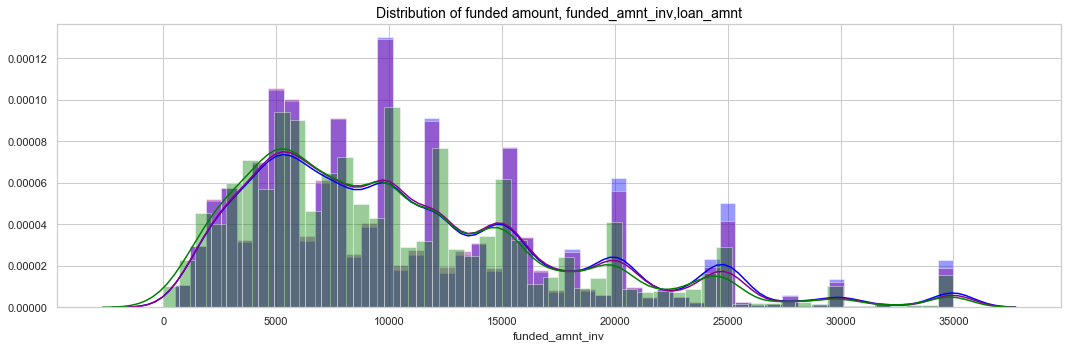

In [48]:
plt.figure(figsize=(15,5))
plt.subplot(1,1,1)
sns.distplot(loan_master_fp_co['loan_amnt'],bins=50,color='blue')
sns.distplot(loan_master_fp_co['funded_amnt'],bins=50,color='darkmagenta')
sns.distplot(loan_master_fp_co['funded_amnt_inv'],bins=50,color='green')
plt.title('Distribution of funded amount, funded_amnt_inv,loan_amnt',{'color' :'black','fontsize':14})

plt.tight_layout()
plt.show()

**Column name: funded_amnt** <br>
The total amount committed to that loan at that point in time.<br>

<mark>**Observation:**</mark> <br>

- Most loans are funded for an amount less than 15000. There are only a few loans of above 25000.
- This is a clear indication that higher funded amounts results in higher chances of defaulting. <br>
    
<mark>**Loan Attribute - Funded Amount Trend**</mark> <br>
<span style="background-color: #ffe8eb"> Around 18.5% people defaulted their loans when funded amount was 16k or above.</span><br>
<span style="background-color: #d8ffb8"> Banks needs to be careful when giving high amount loans. </span>

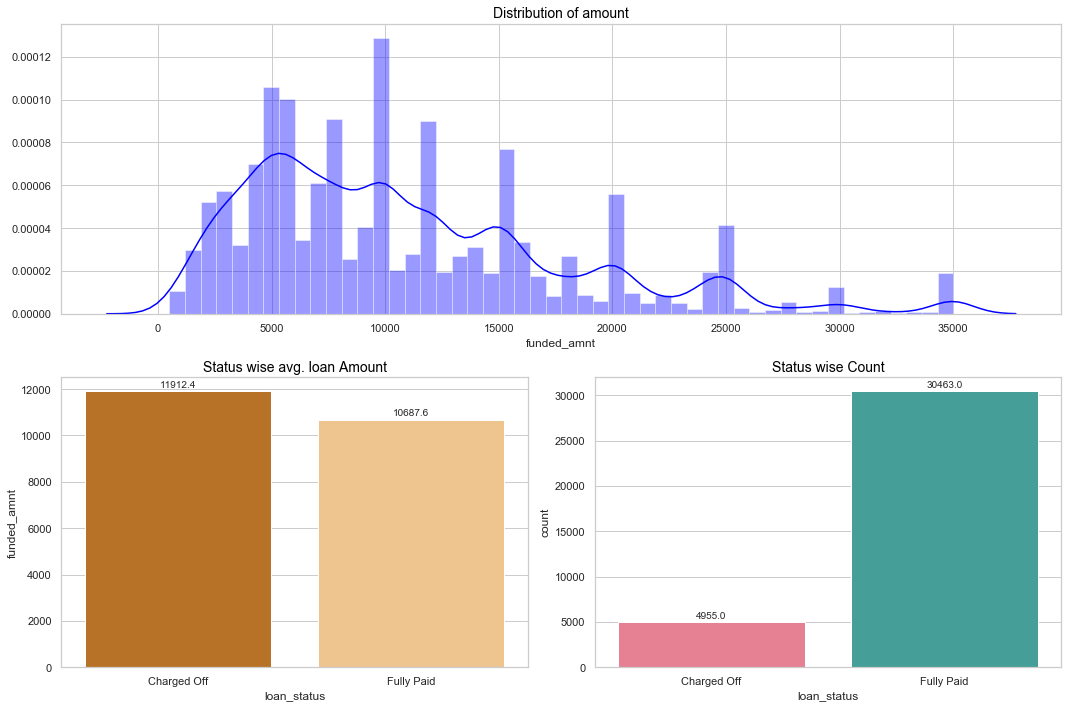

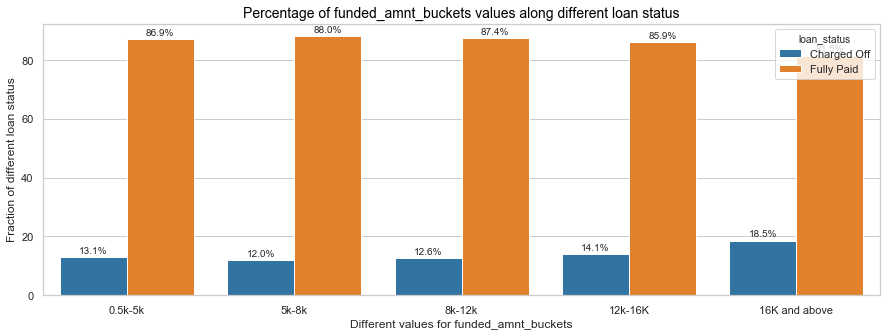

In [49]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.distplot(loan_master_fp_co['funded_amnt'],bins=50,color='blue')
plt.title('Distribution of amount',{'color' :'black','fontsize':14})

plt.subplot(2,2,3)
ax2 = sns.barplot(x='loan_status',y ='funded_amnt', data=loan_master_fp_co,palette=sns.color_palette("PuOr", 5),ci=False)
annotate_bar(ax2)
plt.title('Status wise avg. loan Amount',{'color' :'black','fontsize':14})

plt.subplot(2, 2, 4)
ax1 = sns.countplot(x='loan_status',data=loan_master_fp_co,palette='husl')
annotate_bar(ax1)
plt.title('Status wise Count',{'color' :'black','fontsize':14})

plt.tight_layout()
plt.show()

comparison_plot(loan_master_fp_co, 'funded_amnt_buckets', palette_name='tab10')

**Column name: int_rate** <br>
Interest Rate on the loan<br>

<mark>**Observation:**</mark> <br>
- This is a clear indication that higher interest rates resul in higher rate of defaulting.<br/>

<mark>**Loan Attribute - Interest Rate Trend**</mark><br>
<span style="background-color: #ffe8eb"> 25% of the customers defaults loan when intereset rate more than 15%<br>
<span style="background-color: #d8ffb8"> Since most of the loans are with interest rate below 15%, it is recommended to avoid issuing loans at rates higher than 15% </span>

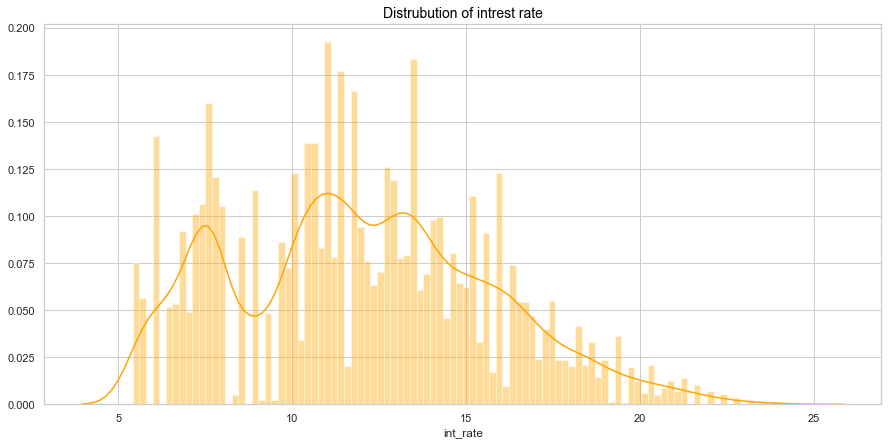

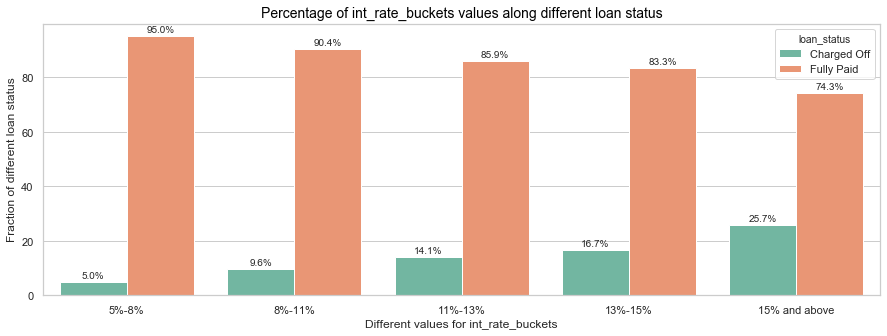

In [50]:
plt.figure(figsize=(15,7))
plt.title(f'Distrubution of intrest rate',{'color' :'black','fontsize':14})
sns.distplot(loan_master_fp_co['int_rate'],bins=100,color='orange')
plt.show()
comparison_plot(loan_master_fp_co, 'int_rate_buckets', palette_name='Set2')

**Column name: term <br>**
The term of loan.<br>

<mark>**Observation:**</mark> <br>
- This is a clear indication that a lot more customers are defaulting for 60 months term.<br>

<mark>**Loan Attribute - Loan Term Trend**</mark><br>
<span style="background-color: #ffe8eb"> 25% of the customers defaults loan when term is 60 months.<br>
<span style="background-color: #d8ffb8"> LC should prefer 36 months term over 60 months. </span>

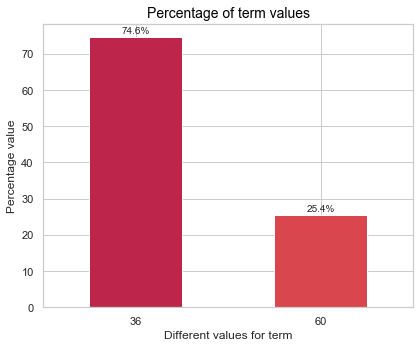

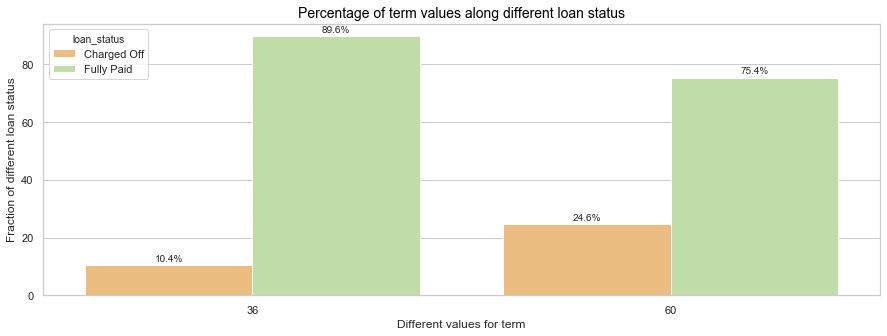

In [51]:
plot_percent(loan_master_fp_co, 'term')
comparison_plot(loan_master_fp_co, 'term', palette_name='Spectral')

**Column name: grade** <br>
LC assigned loan grade<br>

<mark>**Observation:**</mark> <br>
- This is a clear indication that a lot more customers are defaulting for grades lower than D

<mark>**Loan Attribute - Loan Grade Trend**</mark><br>
<span style="background-color: #ffe8eb"> There are high chances of defaulting if loan is Grade D or below.<br>
<span style="background-color: #d8ffb8"> LC should get away with issuing grades F and G loans, as it's less than 3% of business.<br> They should also take precautionary measures while issuing a grade D and grade E loans. </span>

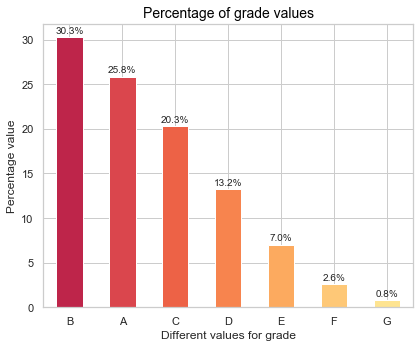

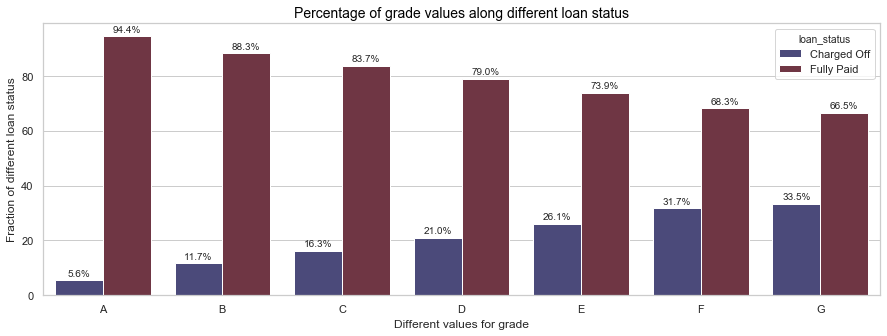

In [52]:
plot_percent(loan_master_fp_co, 'grade')
comparison_plot(loan_master_fp_co, 'grade',palette_name='icefire')

# Customer Attributes

**Column name: home_ownership** <br>

<mark>**Observation** </mark><br>
- People who selected OTHER in home ownership tend to default more.

<mark>**Customer Attribute - Home Ownership Trend**</mark><br>
<span style="background-color: #ffe8eb"> There are high chances of defaulting if home ownerships is selected a 'OTHER'.<br>
<span style="background-color: #d8ffb8"> LC should remove this option of 'OTHER' as it's only 0.3% of business but with a high default rate </span>

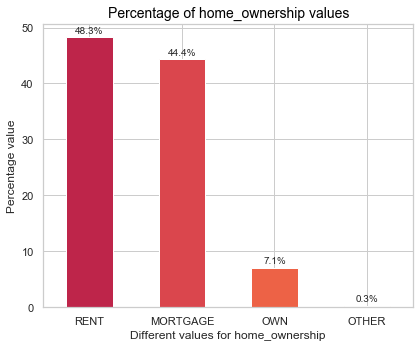

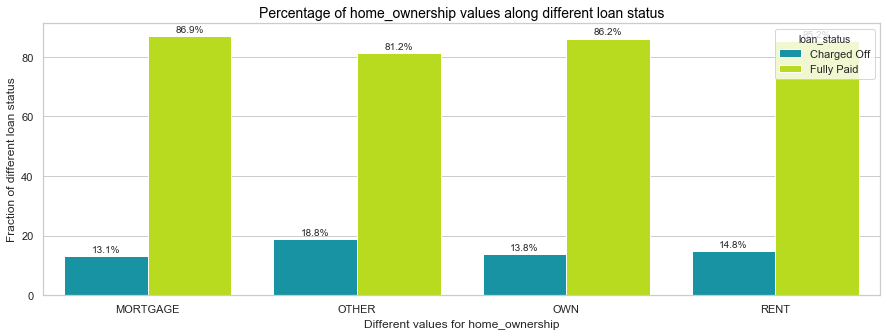

In [53]:
plot_percent(loan_master_fp_co, 'home_ownership')
comparison_plot(loan_master_fp_co, 'home_ownership',palette_name='nipy_spectral')

**Column name: pub_rec_bankruptcies** <br>

<mark>**Observation** </mark><br>
- It is clear from distribution that very few people has piblic record of bankruptcies.

<mark>**Customer Attribute - Public Record Bankruptcies Trend**</mark><br>
<span style="background-color: #ffe8eb"> There are high chances of defaulting if person filed for bankruptcy.<br>
<span style="background-color: #d8ffb8"> LC should stop issuing loans to such applicants.</span>

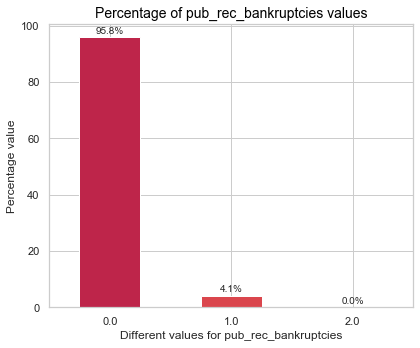

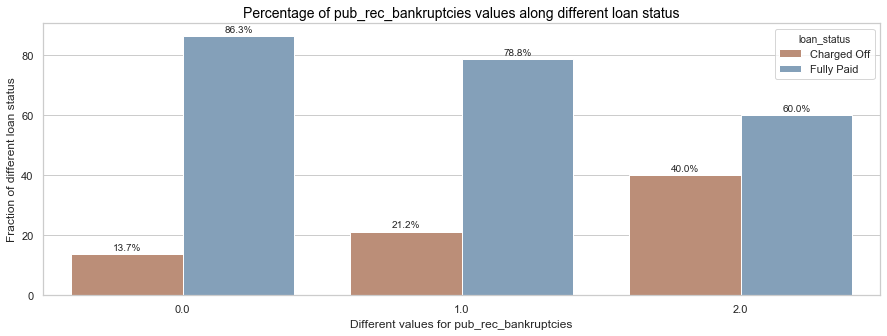

In [54]:
plot_percent(loan_master_fp_co, 'pub_rec_bankruptcies')
comparison_plot(loan_master_fp_co, 'pub_rec_bankruptcies',palette_name='twilight_shifted_r')

**Column name: purpose** <br>
Purpose of loan<br>

<mark>**Observation** </mark><br>
-  'small business','educational' and 'renewable energy' have higher chances of defaulting.

<mark>**Customer Attribute - Loan Purpose Trend**</mark><br>
<span style="background-color: #ffe8eb"> Loan Purpose 'small business','educational' and 'renewable energy' will have high chances of defaulting averaging 20%.<br>
<span style="background-color: #d8ffb8"> Recommend to stop issuing loans for these purposes as it's about 2% of the business anyways, and 20% of them defaults.</span>

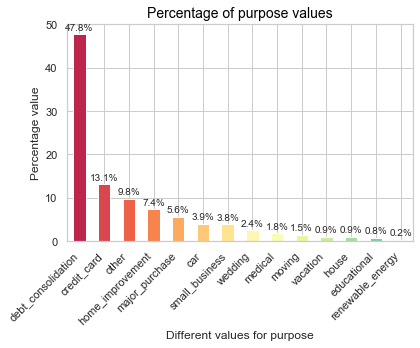

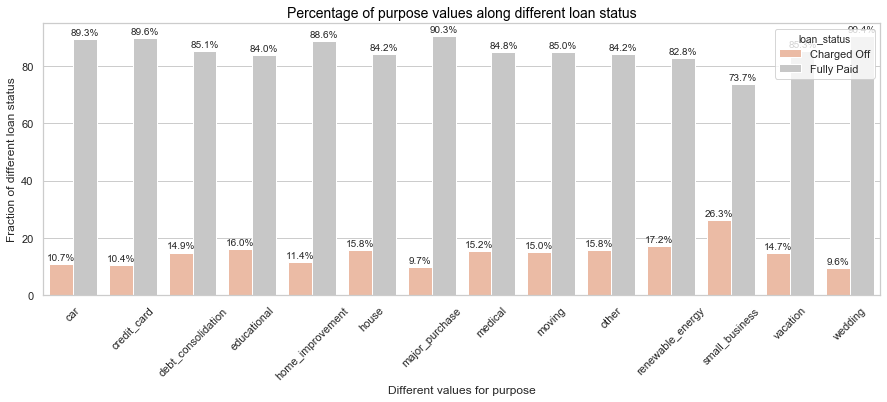

In [55]:
plot_percent(loan_master_fp_co, 'purpose', rotate=True)
comparison_plot(loan_master_fp_co, 'purpose', True,palette_name='RdGy')

**Column name: inq_last_6mths** <br>
<mark>**Observation** </mark><br>
-  Generally chances of defaulting increases with number of inquiries in last 6 months

<mark>**Customer Attribute - Credit Inquiry Last 6 Months Trend**</mark><br>
<span style="background-color: #ffe8eb"> If there are less than 3 inquries in account, then defaulting chances are 15% or less<br>
<span style="background-color: #d8ffb8"> Recommend to issuing loans to people with 3 or less inquries in last 6 months. LC's 99% of current loans are to customers with less than 3 inquries anyways.</span>


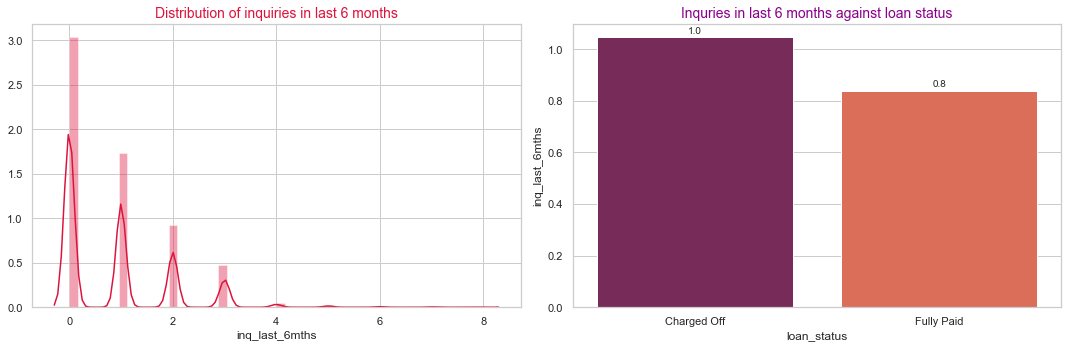

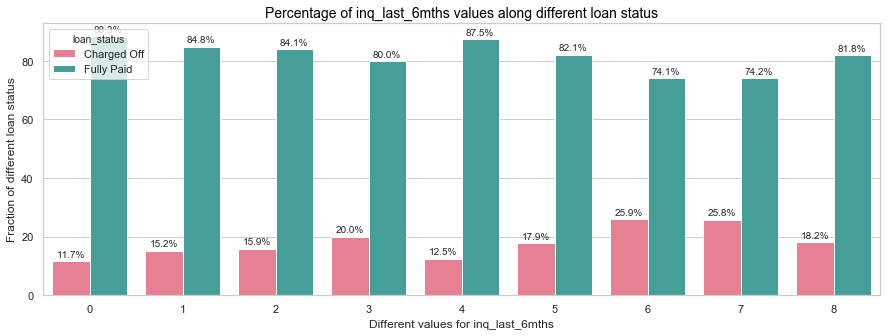

In [56]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
ax2 = sns.distplot(loan_master_fp_co['inq_last_6mths'],color='crimson')
plt.title('Distribution of inquiries in last 6 months',{'color' :'crimson','fontsize':14})

plt.subplot(1,2,2)
ax = sns.barplot(x="loan_status", y="inq_last_6mths", data=loan_master_fp_co, palette="rocket",ci=None)
annotate_bar(ax)
plt.title('Inquries in last 6 months against loan status',{'color' :'DarkMagenta','fontsize':14})

plt.tight_layout()
plt.show()
comparison_plot(loan_master_fp_co, 'inq_last_6mths')

**Column name: annual_inc** <br>
<mark>**Observation:**</mark> <br>
<span style="background-color: #ffe8eb"> Annual income has very minimal significance in determining defaulting vs paid off customers. Customer having lower annual income tends to charge off slight more.<br/>

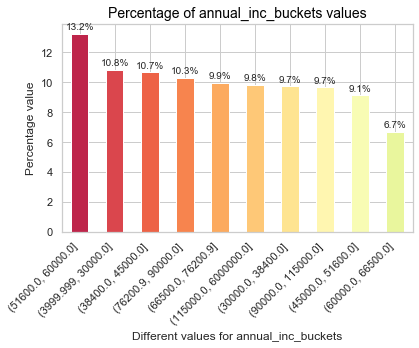

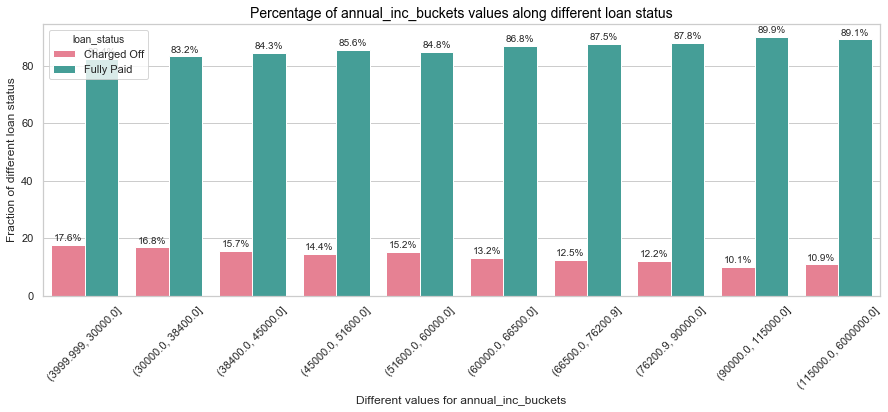

In [57]:
plot_percent(loan_master_fp_co, 'annual_inc_buckets', rotate=True)
comparison_plot(loan_master_fp_co, 'annual_inc_buckets', rotate=True)

### NO TREND ATTRIBUTES - STARTS HERE
#### Loan and Customer attributes that were analyzed. But no significant trend found.
#### Plots disabled by default using plot_for_analysis = False, to avoid longer execution times
#### Section was for self analysis and  can be ignored. And also contains few attributes which will not be present at time of taking loan.
#### Scroll Down till NO TREND ATTRIBUTES end heading.

In [58]:
#make it False to hide less significant plots below.
plot_for_analysis = True

**Column name: installment <br>**
The monthly payment owed by the borrower if the loan originates.<br>

<mark>**Observation**</mark> <br>
- Most customers pay between 200 and 400 dollars in installments<br>
<span style="background-color: #ffe8eb"> Installment Amount is not of significance when determining defaulting vs paid off customers

**Column name: issue_year( derived from issue_d)** <br>

<mark>**Observation**</mark> <br>
- The graphs shows most number of loans were funded in 2011 and least in 2007.<br>
<span style="background-color: #ffe8eb"> The charge off rate is very high in 2011 but not enough data to support it. In 2011 the charge off rate is higher and also data is enough to support this.

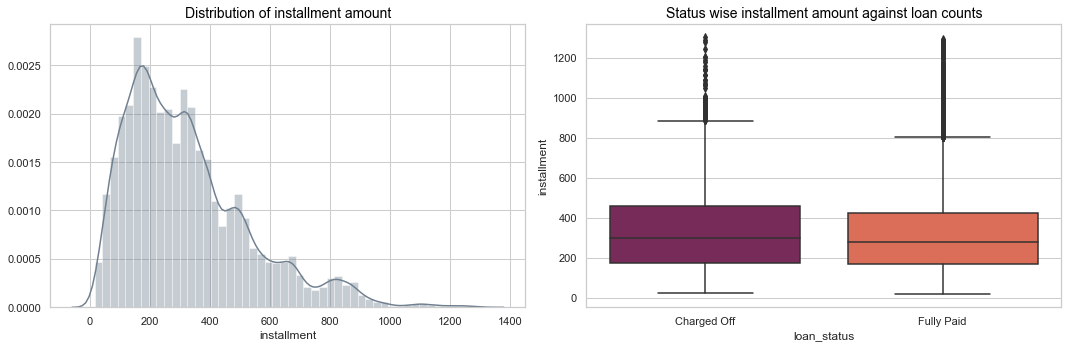

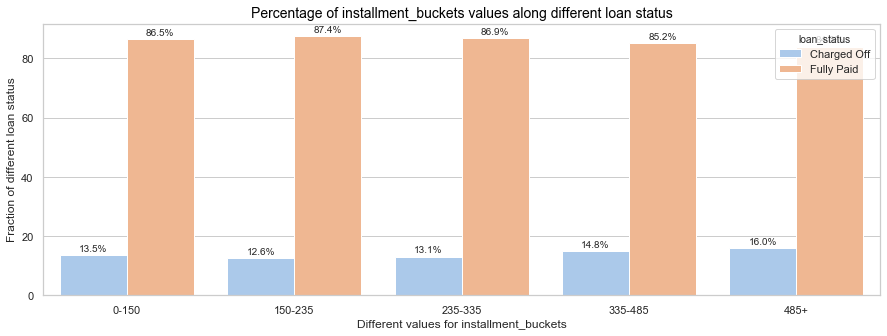

In [59]:
if plot_for_analysis: 
    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    ax2 = sns.distplot(loan_master_fp_co['installment'],color='slategrey')
    plt.title('Distribution of installment amount',{'color' :'black','fontsize':14})

    plt.subplot(1,2,2)
    ax1 = sns.boxplot(x='loan_status',y='installment', data=loan_master_fp_co,palette='rocket')
    plt.title('Status wise installment amount against loan counts',{'color' :'black','fontsize':14})

    plt.tight_layout()
    plt.show()

    comparison_plot(loan_master_fp_co, 'installment_buckets', palette_name='pastel')

**Column name: open_acc** <br>
**Observation** <br>
- <span style="background-color: #d8ffb8"> No significant impact </span>

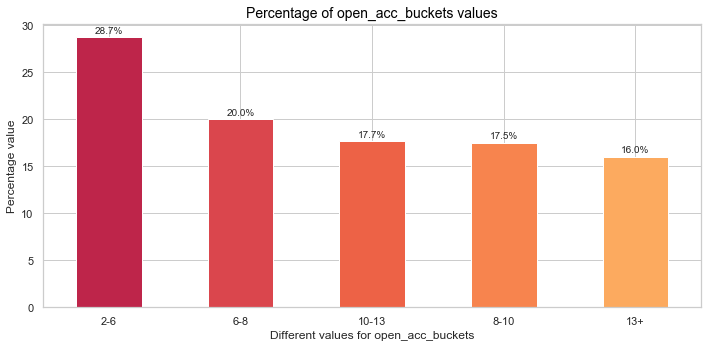

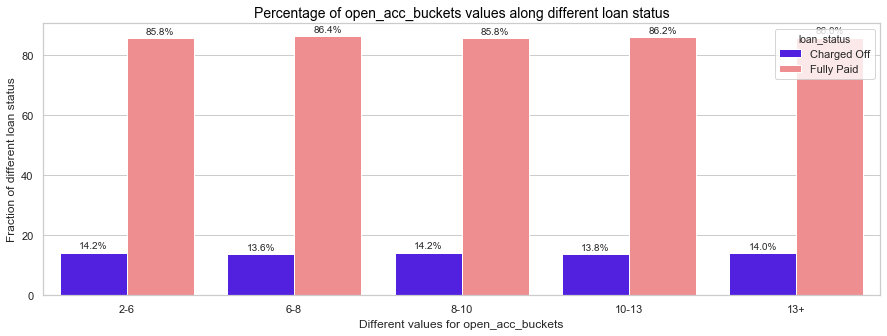

In [60]:
if plot_for_analysis: 
    plot_percent(loan_master_fp_co, 'open_acc_buckets',expand=10)
    comparison_plot(loan_master_fp_co, 'open_acc_buckets',palette_name='gnuplot2')

**Column name: revol_bal** <br>
**Observation** <br>
- <span style="background-color: #ffe8eb"> No significant impact</span>

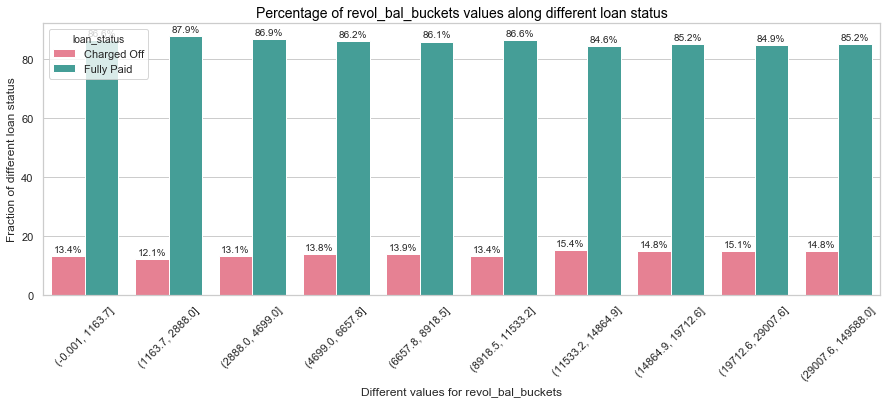

In [61]:
if plot_for_analysis: 
    loan_master_fp_co['revol_bal_buckets'] = pd.qcut(loan_master_fp_co['revol_bal'],10)
    comparison_plot(loan_master_fp_co, 'revol_bal_buckets', rotate=True)

**Column name: earliest_cr_line_year** <br>
**Observation** <br>
- The graphs shows that the distribution is among valid years with most credit lines from year 1995-2005
- <span style="background-color: #d8ffb8">No significant trend</span>

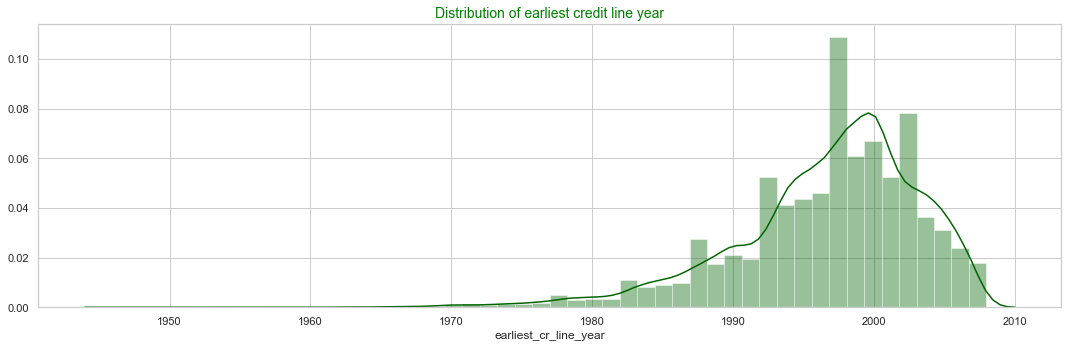

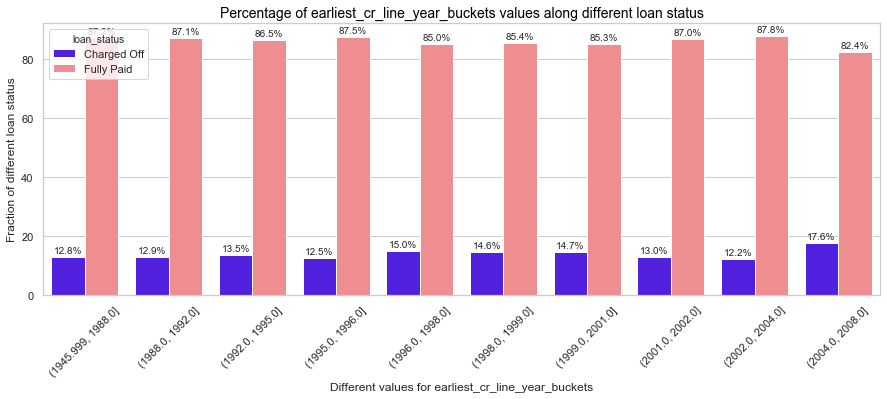

In [62]:
if plot_for_analysis: 
    loan_master_fp_co['earliest_cr_line_year_buckets'] = pd.qcut(loan_master_fp_co['earliest_cr_line_year'],10)
    plt.figure(figsize=(15,5))
    ax2 = sns.distplot(loan_master['earliest_cr_line_year'],bins=50,color='darkgreen')
    plt.title('Distribution of earliest credit line year',{'color' :'green','fontsize':14})
    plt.tight_layout()
    plt.show()
    comparison_plot(loan_master_fp_co, 'earliest_cr_line_year_buckets',rotate=True,palette_name='gnuplot2')

**Column name: verification_status** <br>
**Observation** <br>
- Most of the loans are given without LC verification about income.
- Verification is importatnt to do, but even after verification people are defaulting more than not verified.
- <span style="background-color: #ffe8eb"> Fraction of Charge Off is similar across verification status. There is no strong indication about loan status.

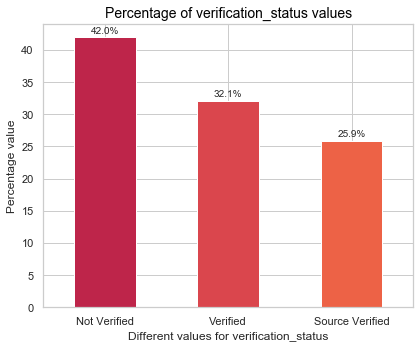

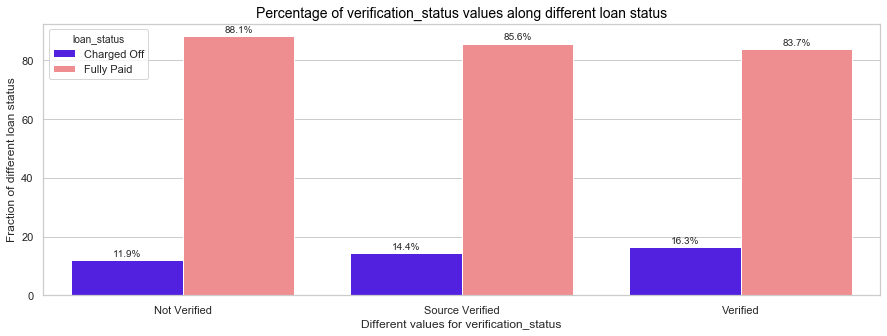

In [63]:
if plot_for_analysis: 
    plot_percent(loan_master_fp_co, 'verification_status')
    comparison_plot(loan_master_fp_co, 'verification_status',palette_name='gnuplot2')

**Column name: last_pymnt_amnt** <br>
**Observation** <br>
- The avg. last payment amount is very less for charged off loans
- <span style="background-color: #d8ffb8">However this difference is due to high number of rows for Fully paid. So, No ipmact. </span>
- 

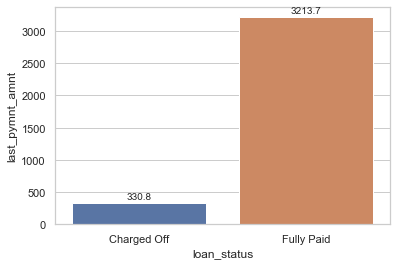

In [64]:
if plot_for_analysis: 
    ax = sns.barplot(x = 'loan_status', y='last_pymnt_amnt',ci=None,data=loan_master_fp_co)
    annotate_bar(ax)

**Column names: out_prncp, out_prncp_inv** <br>
**Observation** <br>
- <span style="background-color: #ffe8eb"> This is not significant for fully paid or charged off categories.</span>

In [65]:
loan_master_fp_co.groupby('loan_status')['out_prncp','out_prncp_inv'].describe()

out_prncp                                           out_prncp_inv  \
                count  mean   std   min   25%   50%   75%   max         count   
loan_status                                                                     
Charged Off  4955.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000      4955.000   
Fully Paid  30463.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000     30463.000   

                                                       
             mean   std   min   25%   50%   75%   max  
loan_status                                            
Charged Off 0.000 0.000 0.000 0.000 0.000 0.000 0.000  
Fully Paid  0.000 0.000 0.000 0.000 0.000 0.000 0.000

**Column name: last_credit_pull_year( derived from last_credit_pull_d)** <br>
**Observation** <br>
- The graphs shows most recent month LC pulled credit for that loan.
- No clear trend

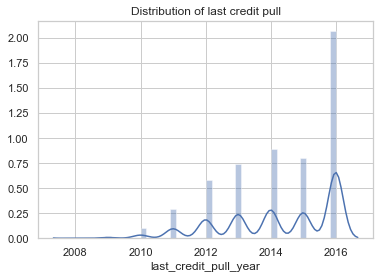

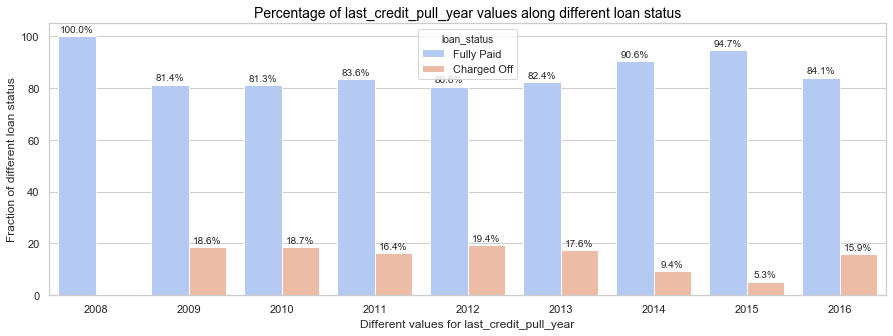

In [66]:
if plot_for_analysis: 
    sns.distplot(loan_master_fp_co['last_credit_pull_year'])
    plt.title('Distribution of last credit pull')
    plt.show()
    comparison_plot(loan_master_fp_co, 'last_credit_pull_year',palette_name='coolwarm')

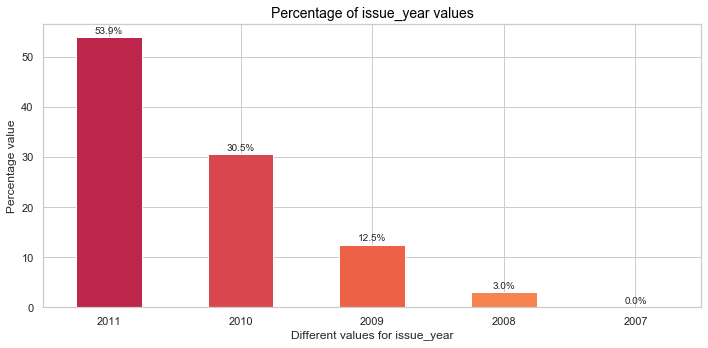

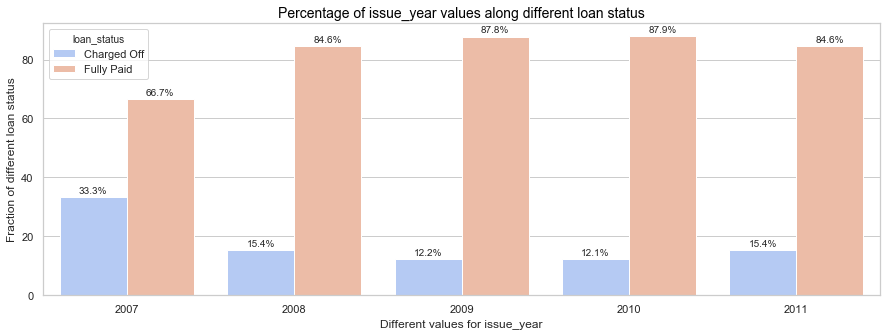

In [67]:
if plot_for_analysis: 
    plot_percent(loan_master_fp_co, 'issue_year',expand=10)
    comparison_plot(loan_master_fp_co, 'issue_year',palette_name='coolwarm')

**Column name: addr_state** <br>
**Observation** <br>
- <span style="background-color: #d8ffb8"> States like AK, FL, NM, NV, SD, TN are having higher charge off rate. </span>
- <span style="background-color: #d8ffb8"> However, these states are with a lot of business for LC. So, no recommendation here. </span>
- Banks should be very careful escpecially long term loans to people from above states.

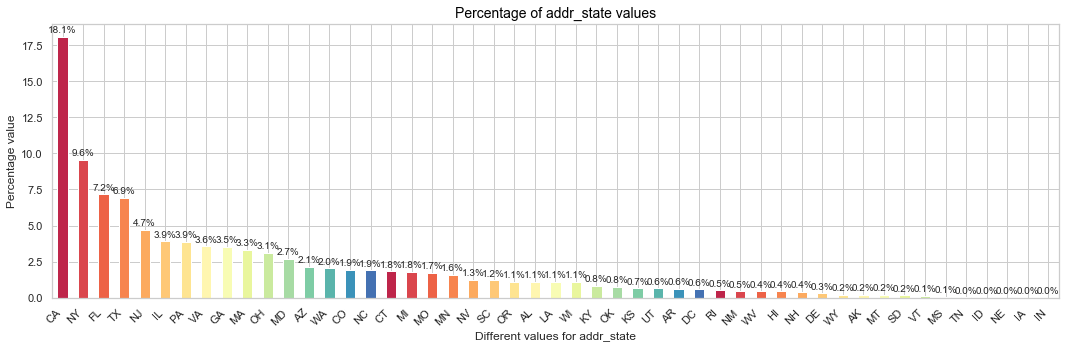

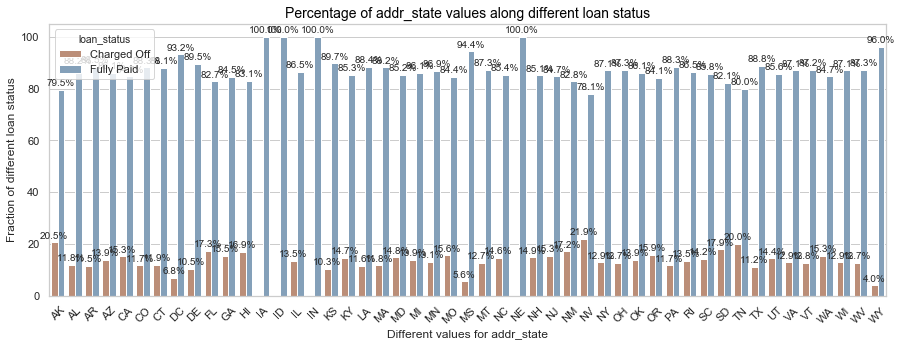

In [68]:
if plot_for_analysis: 
    plot_percent(loan_master_fp_co, 'addr_state',rotate=True,expand=15)
    comparison_plot(loan_master_fp_co, 'addr_state',palette_name='twilight_shifted_r',rotate=True)

**Column names: total_pymnt, total_pymnt_inv** <br>
**Observation** <br>
- <span style="background-color: #ffe8eb"> These attributes may not be present at time of giving loan. So can ignore it.</span>

**Column name: dti** <br>
**Observation** <br>
- When the dti or dept payment to income ratio is higher than 20, higher percentage of loans are Charged Off
- In general,<span style="background-color: #d8ffb8"> higher the dti higher the chances of loan being Charged Off </span>except the extreme dti.
 - But is not clear trending factor.


In [69]:
loan_master_fp_co['dti_bin'] = pd.cut(loan_master_fp_co['dti'], [0,5,10,15,20,25,30], labels=['0-5','5-10','10-15','15-20','20-25','25-30'])

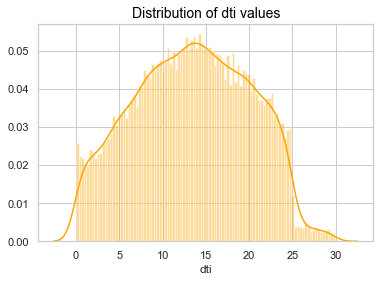

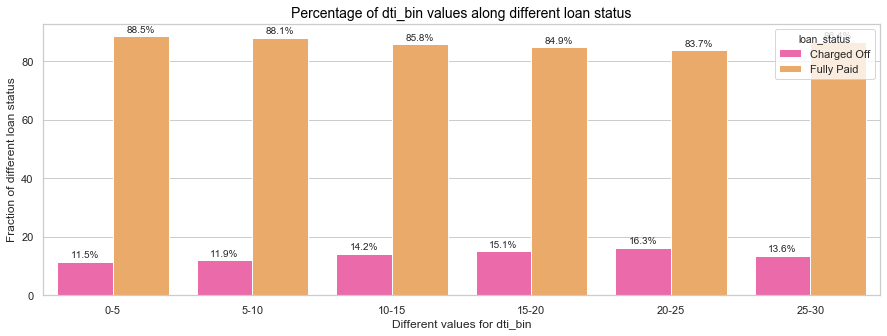

In [70]:
if plot_for_analysis: 
    sns.distplot(loan_master_fp_co['dti'],bins=100,color='orange')
    plt.title(f'Distribution of dti values',{'color' :'black','fontsize':14})
    plt.show()
    comparison_plot(loan_master_fp_co, 'dti_bin',palette_name='spring')

**Column name: delinq_2yrs** <br>
**Observation** <br>
- <span style="background-color: #ffe8eb"> There is very less points for delinq more than 0. So any insight from this column will be highly biased. So we will not infer this attribute </span>

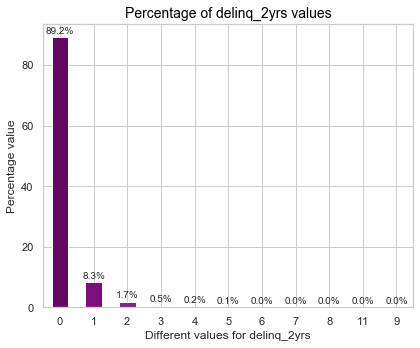

In [71]:
if plot_for_analysis: 
    plot_percent(loan_master_fp_co, 'delinq_2yrs',palette_name='BuPu_r')

**Column name: emp_title** <br>
Purpose of loan<br>

<mark>**Observation**</mark> <br>
- People from US Army and Bank of America are among top loan borrowers, folllowed by companies like IBM, AT&T, Wells Fargo
- <span style="background-color: #ffe8eb"> emp_title does not seems having a strog influence on loan status. </span> But seems people from walmart are having higher charge off rate.

In [72]:
top10_emp = pd.DataFrame(loan_master['emp_title'].value_counts()[:20])
top10_title = top10_emp.index.values
top10_title = loan_master_fp_co[loan_master_fp_co['emp_title'].isin(top10_title)]

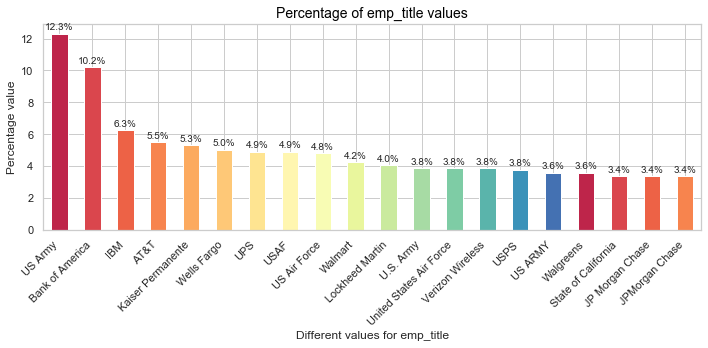

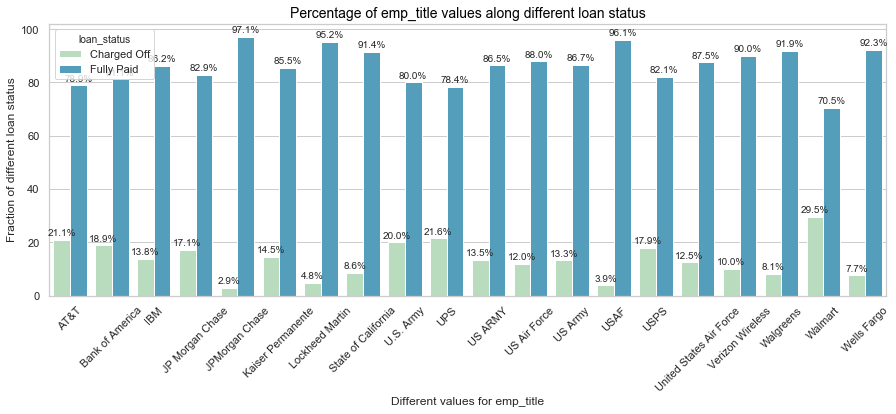

In [73]:
if plot_for_analysis: 
    plot_percent(top10_title, 'emp_title', rotate=True,expand=10)
    comparison_plot(top10_title, 'emp_title', True,palette_name='GnBu')

**Column name: emp_length** <br>


**Observation** <br>
- No employment length has a very clear distinction of loan status.
- <span style="background-color: #ffe8eb">There is no strong indicator based on employment length.</span>

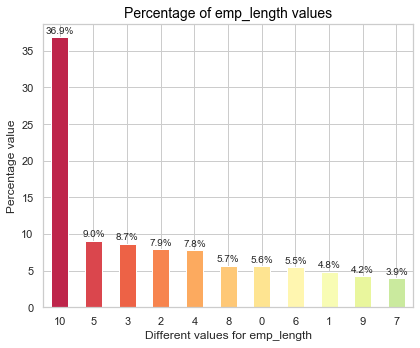

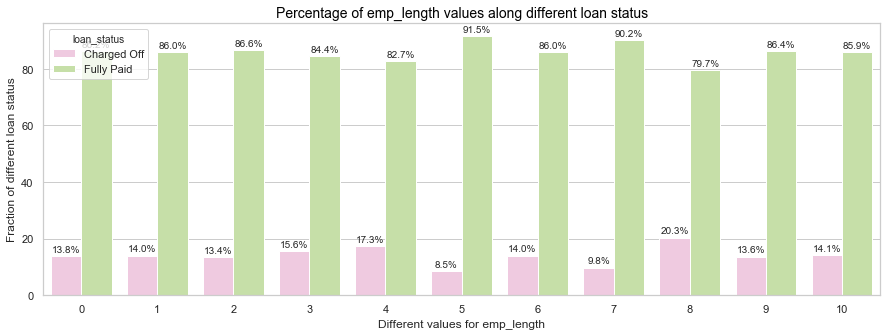

In [74]:
if plot_for_analysis: 
    plot_percent(top10_title, 'emp_length')
    comparison_plot(top10_title, 'emp_length',palette_name='PiYG')

### NO TREND ATTRIBUTES - ENDS HERE

## Bivariate Analysis

**Relation between some key variables<br>
Observations:**
- Dark color shows some highly correlated attributes
- Heatmap gives quick rough correlation between variables
- Positive value denotes direct proportion and negative value denotes inverse proportion

In [75]:
attributes_considered = ['loan_amnt', 'int_rate', 'installment','emp_length', 'annual_inc','dti', 'delinq_2yrs',
                        'inq_last_6mths', 'pub_rec', 'last_pymnt_amnt', 'pub_rec_bankruptcies','total_pymnt','open_acc',
                         'installment','term','loan_status']
df_for_heatmap = loan_master_fp_co[attributes_considered]
df_for_heatmap = df_for_heatmap.replace({'loan_status': {'Fully Paid':0,'Charged Off':1}})

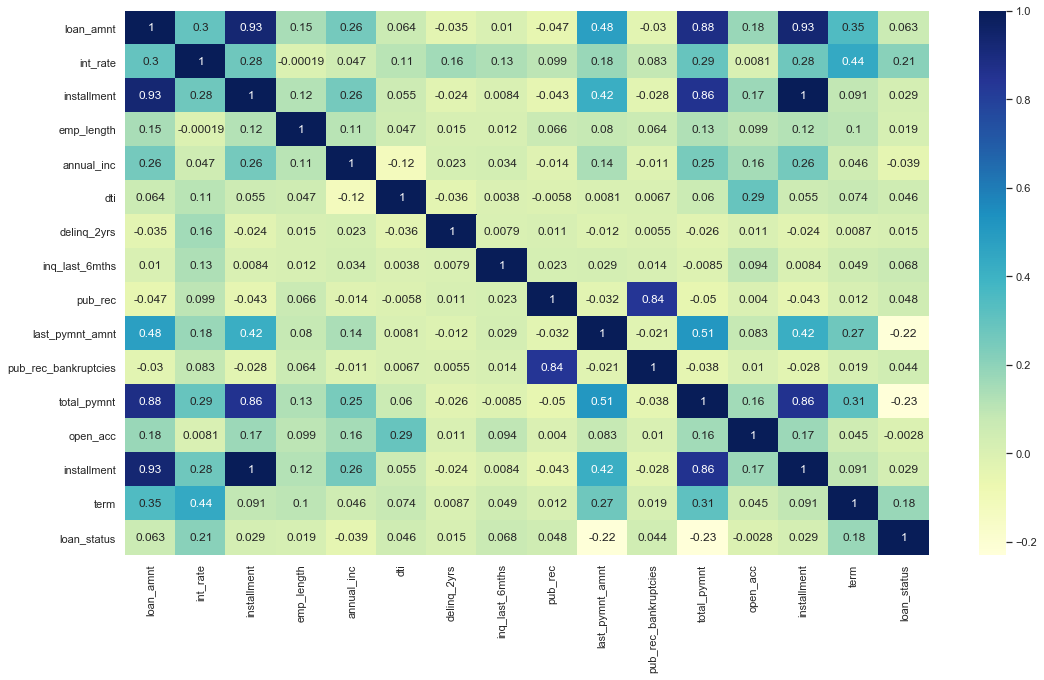

In [76]:
plt.figure(figsize=(18,10))
sns.heatmap(df_for_heatmap.corr(),annot=True,cmap="YlGnBu")
plt.show()

**Term and Grade** <br>
<mark>**Observation** </mark><br>
<span style="background-color: #ffe8eb"> For 36 months, grades D and below averages 20% default rate <br>
<span style="background-color: #ffe8eb"> For 60 months, grades D and below averages 30% default rate <br>

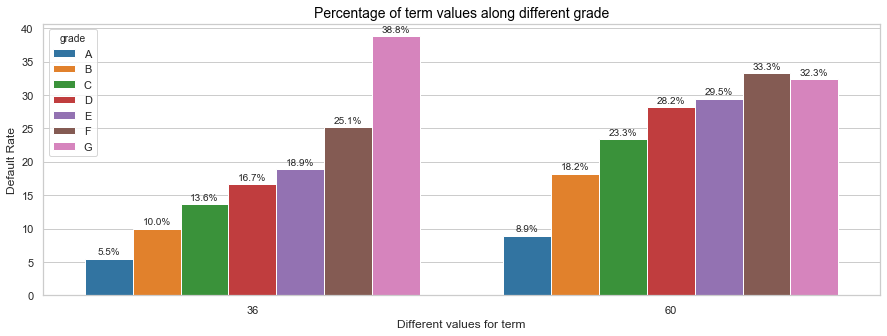

In [77]:
comparison_plot_bivariate(loan_master_fp_co,'term','grade',palette_name='tab10')

**Analysis of loan amount based on home ownership status**
- In low income group, a lit of people default who rent or own a house
- In higher income groups, a lot of people default who define their home ownership as OTHERS

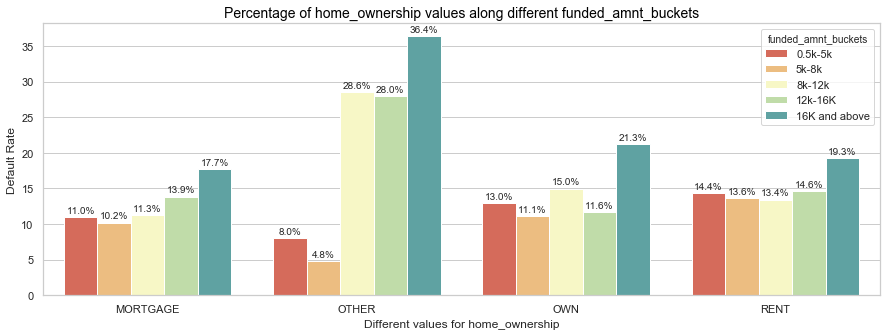

In [78]:
comparison_plot_bivariate(loan_master_fp_co, 'home_ownership','funded_amnt_buckets', palette_name='Spectral')

**purpose and funded amnt**
- Out of most defaulted loan purposes, for small businessther are high loan amounts funded over 12K and there is avg 30% chances of them getting defaulted.

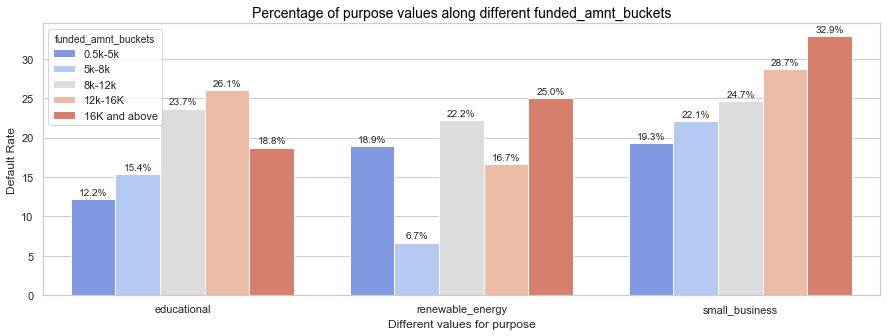

In [79]:
df =loan_master_fp_co[loan_master_fp_co['purpose'].isin(['small_business','educational','renewable_energy'])]
comparison_plot_bivariate(df, 'purpose','funded_amnt_buckets', palette_name='coolwarm')

**loan_amnt over time**
- The trend shows increase in number of loans taken over the years

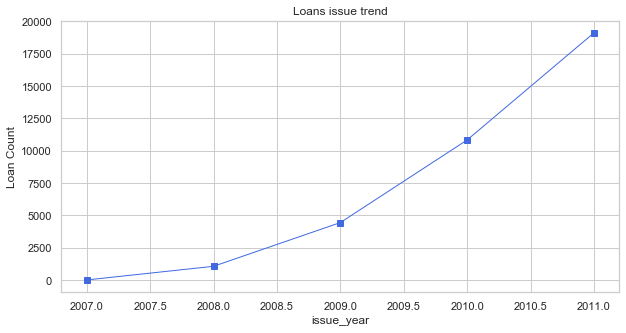

In [80]:
plt.figure(figsize=(10,5))
loan_master_fp_co.groupby('issue_year').loan_amnt.count().plot(kind='line',color='royalblue',marker='s',linewidth=1)
plt.ylabel('Loan Count')
plt.title('Loans issue trend')
plt.show()

**Average loan amount over the time**
- There is a dip in 2008 in average loan amount. This may be because of the great recession world wide.

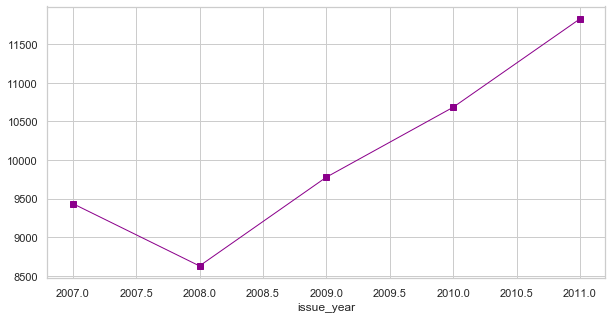

In [81]:
plt.figure(figsize=(10,5))
loan_master_fp_co.groupby('issue_year').loan_amnt.mean().plot(kind='line',color='darkmagenta',marker='s',linewidth=1)
plt.show()

**Interest rate with respect to loan grade**
- As the loan grade increases, the interest rate increases.

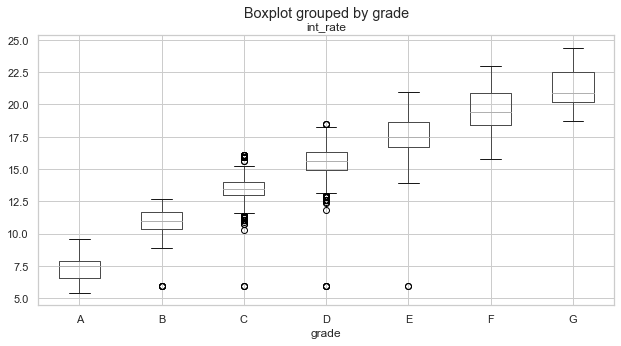

In [82]:
loan_master_fp_co.boxplot(column='int_rate', by='grade',figsize=(10,5))
plt.show()

**Loan amount and Annual income relation**
- As the Annual income inreases the Loan amount increases. 
- We can see that people having Annual income near to 5000 has taken some higher loan amount.

<Figure size 720x720 with 0 Axes>

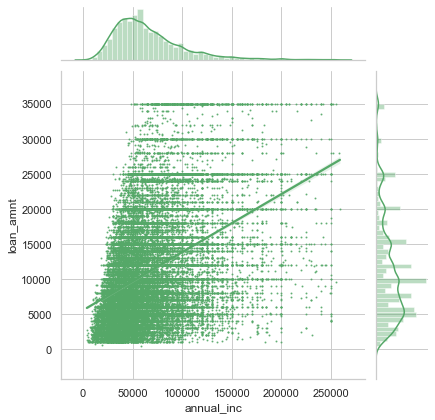

In [83]:
plt.figure(figsize=(10,10))
sns.jointplot('annual_inc', 'loan_amnt',loan_master_fp_co[loan_master_fp_co['annual_inc']<260000],kind='reg',color='g',scatter_kws={"s": 1})
plt.show()

**Distrubution of interest rate across years. <br>
Observations:**
- Distrubution of interest rate in 2008 is less while it is higher in 2011. People across all interest rates has charged Off over the years.

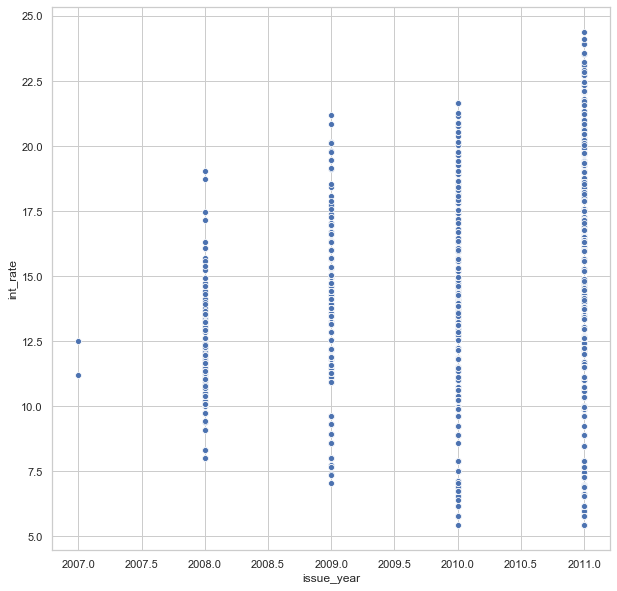

In [84]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=loan_master_fp_co[loan_master_fp_co['loan_status']=='Charged Off'], y="int_rate", x="issue_year",palette='dark')
plt.show()

**We can see how over the year the average interest rate has varied. It started low and moved higher in 2011, being highest in 2009. This may be bacuse banks are recovering from 2008 recession.**

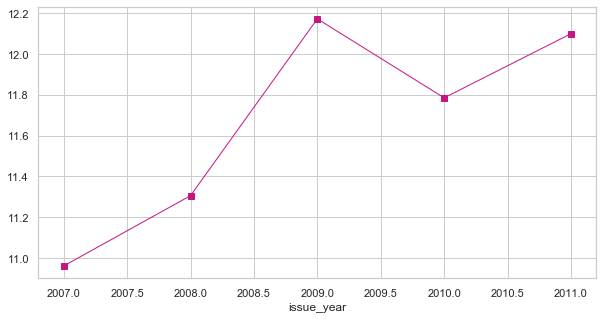

In [85]:
plt.figure(figsize=(10,5))
loan_master_fp_co.groupby('issue_year').int_rate.mean().plot(kind='line',color='mediumvioletred',marker='s',linewidth=1)
plt.show()

# RECOMMENDATIONS

- Do not issue a loan if there is a single bankruptcy record on borrower's public file.
- Do not allow the option of 'Other' home ownership in the loan application.
- Do not issue high amount loans above \$16K to borrowers who own or rent a house.
- Stop issuing loan for Small Business purpose.
- Stop issuing higher amount loans above \$8K for Educational and Renewable Energy purposes.
-  Scrutinize loans for borrowers with 3 or more inquiries in last 6 months.
- Perform extra checks when issuing loans higher than 16k, as default rate is much higher there.
- Avoid issuing loans at rates higher than 15%.
- Completely stop issuing grades F and G loans.
- Stop issuing grade D and E loans for 60 months term.